### **Articles Summarization and Evaluation**

* In this notebook we will cover the evaluation of summaries generated both extractively(TF-IDF) and abstractivly(MBart Pre-Trained).
* The summaries will be then constructed in a combination of both of the techniques, as some sort of hybrid summarization.
* Various metrics then are applied to evalute the sentences of the generted texts in the perspective of the original ones.
* The metrics are  `ROUGE1`, `ROUGE2`, `ROUGE-L`, `ROUGE-Lsum` and `BLEU1`, `BLEU2`, `BLEU3`, `BLEU4` (Their averge sum over the count of all articles).  

#### *Extractive Summary*

In [ ]:
import os, json
import re
import math
import numpy as np
import networkx as nx
import operator
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
Stopwords = set(stopwords.words('russian'))
wordlemmatizer = WordNetLemmatizer()

In [ ]:
def load_dataset(file_name):
    with open(file_name, 'rb') as articles_set:
        dataset = json.load(articles_set)
    return dataset

In [ ]:
def removeSpecialCharacters(text):
    regex = r'[^a-zA-Z0-9\s]'
    text = re.sub(regex,'',text)
    return text

In [ ]:
def tokenizeSentences(text):
    #Tokenize Sentences
    tokenized_sentence = sent_tokenize(text)
    #Removing Special Characters
    text = removeSpecialCharacters(str(text))
    text = re.sub(r'\d+', '', text)
    #Tokenize Words
    tokenized_words = word_tokenize(text)
    word_count = len(tokenized_words)
    #Remove Stop Words
    tokenized_words_without_stopwords = [word for word in tokenized_words if word not in Stopwords]
    #Remove Single Letter words
    tokenized_words_without_stopwords = [word for word in tokenized_words_without_stopwords if len(word) > 1]
    #Convert all tokenized words into lower case to remove ambiguity
    tokenized_words_without_stopwords = [word.lower() for word in tokenized_words_without_stopwords]
    return tokenized_words_without_stopwords, tokenized_sentence, word_count

In [ ]:
def calculateWordFrequency(words_list):
    words_list = [word.lower() for word in words_list]
    frequency = {}
    unique_words = []
    #Find all unique words
    for word in words_list:
        if word not in unique_words:
            unique_words.append(word)
    for word in unique_words:
          frequency[word] = words_list.count(word)
    return frequency

In [ ]:
def posTagging(text):
    pos_tag = nltk.pos_tag(text.split())
    pos_tagged_noun_verb = []
    for word,tag in pos_tag:
        if tag == "NN" or tag == "NNP" or tag == "NNS" or tag == "VB" or tag == "VBD" or tag == "VBG" or tag == "VBN" or tag == "VBP" or tag == "VBZ":
            pos_tagged_noun_verb.append(word)
    return pos_tagged_noun_verb

In [ ]:
def stemWords(words):
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

In [ ]:
def lemmatizeWords(words):
    lemmatized_words = []
    for word in words:
        lemmatized_words.append(wordlemmatizer.lemmatize(word))
    return lemmatized_words


In [ ]:
def tfScore(word,sentence):
    freq_sum = 0
    word_frequency_in_sentence = 0
    len_sentence = len(sentence)
    for word_in_sentence in sentence.split():
        if word == word_in_sentence:
            word_frequency_in_sentence = word_frequency_in_sentence + 1
    tf =  word_frequency_in_sentence/ len_sentence
    return tf

In [ ]:
def idfScore(no_of_sentences,word,sentences):
    no_of_sentence_containing_word = 0
    for sentence in sentences:
        sentence = removeSpecialCharacters(str(sentence))
        sentence = re.sub(r'\d+', '', sentence)
        sentence = sentence.split()
        sentence = [word for word in sentence if word.lower() not in Stopwords and len(word)>1]
        sentence = [word.lower() for word in sentence]
        sentence = [wordlemmatizer.lemmatize(word) for word in sentence]
        if word in sentence:
            no_of_sentence_containing_word = no_of_sentence_containing_word + 1
    idf = math.log10(no_of_sentences/no_of_sentence_containing_word)
    return idf

In [ ]:
def calculateTfIdfScore(tf,idf):
    return tf*idf

In [ ]:
def tfidfAllWords(dict_freq,word,sentences,sentence):
    word_tfidf = []
    tf = tfScore(word,sentence)
    idf = idfScore(len(sentences),word,sentences)
    tf_idf = calculateTfIdfScore(tf,idf)
    return tf_idf

In [ ]:
def calculateSentenceScore(sentence,frequency,sentences):
    sentence_score = 0
    sentence = removeSpecialCharacters(str(sentence))
    sentence = re.sub(r'\d+', '', sentence)
    pos_tagged_sentence = []
    no_of_sentences = len(sentences)
    pos_tagged_sentence = posTagging(sentence)
    for word in pos_tagged_sentence:
        if word.lower() not in Stopwords and word not in Stopwords and len(word)>1:
            word = word.lower() 
            word = wordlemmatizer.lemmatize(word)
            sentence_score = sentence_score + tfidfAllWords(frequency,word,sentences,sentence)
    return sentence_score

In [ ]:
def get_extractive_summary(retention_percentage, text):
    tokenized_words, tokenized_sentences, word_count = tokenizeSentences(text)
    tokenized_words = lemmatizeWords(tokenized_words)
    word_frequency = calculateWordFrequency(tokenized_words)

    """Taking input from the user: Percentage of retained context from the original text in the summary"""
    default_retention_percentage = 15
    default_overflow_percentage = 90

    if retention_percentage<=30:
        default_retention_percentage = default_retention_percentage*2
    elif retention_percentage >=75:
        default_retention_percentage = 0

    if retention_percentage + default_retention_percentage >= 100:
        int(((default_overflow_percentage) * len(tokenized_sentences))/100)
    else:
        no_of_sentences = int(((retention_percentage + default_retention_percentage) * len(tokenized_sentences))/100)
    #print("Number of sentences in the summary: ", no_of_sentences, "\nTotal number of sentences: ", len(tokenized_sentences))


    """Generate summary by sorting the sentences based on the sum of tf-idf scores of all the words in the sentence."""
    c = 1
    sentence_scores = {}
    for sent in tokenized_sentences:
        sentence_importance = calculateSentenceScore(sent,word_frequency,tokenized_sentences)
        sentence_scores[c] = sentence_importance
        c = c+1
    sentence_scores = sorted(sentence_scores.items(), key=operator.itemgetter(1),reverse=True)
    count = 0
    summary = []
    sentence_no = []
    for word in sentence_scores:
        if count < no_of_sentences:
            sentence_no.append(word[0])
            count = count+1
        else:
            break
    sentence_no.sort()
    count = 1
    for sentence in tokenized_sentences:
        if count in sentence_no:
            summary.append(sentence)
        count = count+1
    summary = " ".join(summary)
    return summary, retention_percentage, no_of_sentences, word_count, default_retention_percentage, tokenized_sentences, tokenized_words

#### Abstractive Summarization

In [ ]:
# !pip install datasets transformers[sentencepiece]
# !pip install sentencepiece

In [ ]:
from transformers import MBartTokenizer, MBartForConditionalGeneration, BartConfig
from transformers import pipeline

model_name = "IlyaGusev/mbart_ru_sum_gazeta"
bart_tokenizer = MBartTokenizer.from_pretrained(model_name)
bart_model = MBartForConditionalGeneration.from_pretrained(model_name)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.23G [00:00<?, ?B/s]

In [ ]:
def nest_sentences(document):
    nested = []
    sent = []
    length = 0
    token =  nltk.sent_tokenize(document)
    for sentence in token:
        length += len(sentence.split(' '))
        if length < 256:
            sent.append(sentence)
        else:
            nested.append(sent)
            sent = []
            length = 0

    if sent:
        nested.append(sent)

    #print("Nested: ", nested)
#     print("Nested Count: ", len(nested))
#     for i in nested:
#         print("Sentence count in each nested list: ", len(i))
    return nested

In [ ]:
def generate_summary(nested_sentences, min_summary_length, max_summary_length):
    device = 'cuda'
    summaries = []
    for nested in nested_sentences:
        input_tokenized = bart_tokenizer.encode(' '.join(nested), truncation=False, return_tensors='pt', add_special_tokens = False, verbose = True)
        #input_tokenized = input_tokenized.to(device)
        summary_ids = bart_model.generate(input_tokenized,                          
                                          num_beams=5,
                                          no_repeat_ngram_size=2,
                                          min_length = min_summary_length,
                                          max_length = max_summary_length)
        output = [bart_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summary_ids]
        summaries.append(output)
        #summaries = [sentence for sublist in summaries for sentence in sublist]
    return summaries

In [ ]:
data[4][1]

' Суд признал Хёрд виновной в клевете и обязал выплатить Деппу $15 млн Суд признал Эмбер Хёрд виновной в клевете и обязал выплатить Джонни Деппу $15 млн Суд присяжных присудил Деппу $10 млн в качестве компенсации за ущерб и $5 млн в качестве штрафных санкций. В свою очередь, Хёрд также получит $2 млн компенсации за моральный ущерб Суд присяжных в Вирджинии (США) присудил $15 млн компенсации актеру Джонни Деппу по иску о клевете против его бывшей жены Эмбер Хёрд. По мнению присяжных, актриса опорочила своего бывшего супруга, передает Reuters. Присяжные приняли решение в процессе о диффамации между бывшими супругами после 14 часов обсуждения. Деппу присудили $10 млн в качестве компенсации за ущерб и $5 млн в качестве штрафных санкций. В то же время Хёрд также получит $2 млн компенсации за моральный ущерб. www.adv.rbc.ru Судебный процесс между Хёрд и Деппом продолжается с апреля, присяжные заседатели заслушали в общей сложности более 100 часов показаний. Он должен был начаться еще в 2019 

In [ ]:
def get_abstractive_summary(extractive_summary, extractive_retention_percentage, extractive_word_count, extractive_num_sentences, default_retention_percentage_extractive):
    DOCUMENT = extractive_summary
    start = '<START>'
    end = '<END>'
    DOCUMENT = start + DOCUMENT +end
    DOCUMENT = re.sub(r'\n|\r', ' ', DOCUMENT)
    DOCUMENT = re.sub(r' +', ' ', DOCUMENT)
    DOCUMENT = DOCUMENT.strip()
    nested = nest_sentences(DOCUMENT)
    default_error_percentage = 15
    min_summary_length = int((((extractive_retention_percentage - default_error_percentage)/100)*extractive_word_count)/len(nested))
    max_summary_length = int(((extractive_retention_percentage + default_error_percentage)/100)*extractive_word_count/len(nested)) + 100
    #print("Min summary length", min_summary_length)
    #print("Max summary length", max_summary_length)
    #print("Extractive Number of Sentences", extractive_num_sentences)
    if extractive_retention_percentage>75:
        hybrid_summary = extractive_summary
        hybrid_retention_percentage = extractive_retention_percentage
    else:
        hybrid_summary = generate_summary(nested, min_summary_length, max_summary_length)
        hybrid_retention_percentage = extractive_retention_percentage
    return hybrid_summary, hybrid_retention_percentage

In [ ]:
def get_hybrid_summary(retention_percentage, text):
    extractive_summary = get_extractive_summary(retention_percentage, text)
    hybrid_summary = get_abstractive_summary(extractive_summary[0], extractive_summary[1], extractive_summary[3], extractive_summary[2], extractive_summary[4])
    return hybrid_summary[0][0][0]


Summary Evaluation

In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge_score import rouge_scorer
import string
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.translate import bleu

In [ ]:
def calculateRougeScore(summary, reference):
    #Rouge N: N-gram scoring
    #Rouge L: sentence-level: Compute longest common subsequence (LCS) between two pieces of text. Newlines are ignored.
    #RougeLsum: summary-level: Newlines in the text are interpreted as sentence boundaries, and the LCS is computed between each pair of reference and candidate sentences, and something called union-LCS is computed.
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum', 'rougeL'], use_stemmer=True)
    scores = scorer.score(summary,reference)
    return scores

In [ ]:
def getTokens(test):
    test = test.translate(str.maketrans('','',string.punctuation))
    test_list = word_tokenize(test)
    return test_list


In [ ]:
def calculateBleuScore(summary, reference):
    summary_tokens = getTokens(summary)
    reference_tokens = getTokens(reference)
    reference_tokens = [reference_tokens]
    smoothie = SmoothingFunction().method1
    weights_unigram = (1, 0, 0, 0)
    weights_bigram = (0, 1, 0, 0)
    weights_trigram = (0, 0, 1, 0)
    weights_fourgram = (0, 0, 0, 1)
    bleu_score_unigram = sentence_bleu(reference_tokens,summary_tokens,smoothing_function=smoothie, weights = weights_unigram) #BLEU-1,2,3,4
    bleu_score_bigram = sentence_bleu(reference_tokens,summary_tokens,smoothing_function=smoothie, weights = weights_bigram)
    bleu_score_trigram = sentence_bleu(reference_tokens,summary_tokens,smoothing_function=smoothie, weights = weights_trigram)
    bleu_score_fourgram = sentence_bleu(reference_tokens,summary_tokens,smoothing_function=smoothie, weights = weights_fourgram)
    return bleu_score_unigram, bleu_score_bigram, bleu_score_trigram, bleu_score_fourgram

In [ ]:
text = "Reuters назвал нового главного перестраховщика танкеров из России Reuters узнал, что РНПК стала главным перестраховщиком танкеров из России РНПК стала ключевым перестраховщиком российских танкеров, сообщил Reuters. Ранее ЕС запретил страхование и перестрахование морских перевозок российской нефти в третьи страны и, как пишет FT, согласовал этот запрет с Британией Российская национальная перестраховочная компания (РНПК) стала основным перестраховщиком для российских судов, в том числе для танкеров «Совкомфлота», после введения западных санкций, сообщили источники Reuters. Они предположили, что гарантий, предоставляемых РНПК российским страховщикам, будет достаточно, чтобы обеспечивать работу российских танкеров без привлечения западных компаний, которые не готовы работать с Россией. «Увеличение гарантированного капитала РНПК (до 750 млрд руб., о чем в марте объявил ЦБ. — РБК) расширит возможности российских страховщиков в сфере перестрахования рисков внутри России и управления новыми санкционными рисками», — сказал источник агентства. www.adv.rbc.ru При этом другой собеседник Reuters предположил, что средства РНПК могут быть быстро исчерпаны, поскольку сфера деятельности компании не ограничивается сектором морских перевозок. www.adv.rbc.ru 3 июня Евросоюз утвердил шестой пакет санкций против России. Помимо частичного нефтяного эмбарго в него вошел запрет на страхование и перестрахование морских перевозок российской нефти и нефтепродуктов в третьи страны. Как сообщила Financial Times, Евросоюз договорился об этом запрете и с Великобританией. Возможность его введения также рассматривают страны «Большой семерки», однако подобные меры не вступят в силу в ближайшие полгода, пишет издание. При этом Великобритания является ведущим игроком как в области взаимного страхования (P&I), так и в сфере страхования самих судов (H&M). В Лондоне базируется Международная группа клубов взаимного страхования судовладельцев (International Group of P&I Clubs, или IG P&I), и семь из 13 связанных с ней клубов также расположены в британской столице. По данным IG P&I, ее участники обеспечивают покрытие 90% мирового тоннажа морских судов. Также в Лондоне находится Lloyd's of London — рынок страхования и перестрахования. Авторы Теги"
gold_summary = "РНПК стала ключевым перестраховщиком российских танкеров, сообщил Reuters. Ранее ЕС запретил страхование и перестрахование морских перевозок российской нефти в третьи страны и, как пишет FT, согласовал этот запрет с Британией"
generated_summary = get_hybrid_summary(60, text)

In [ ]:
print("Text: ", text)

Text:  Reuters назвал нового главного перестраховщика танкеров из России Reuters узнал, что РНПК стала главным перестраховщиком танкеров из России РНПК стала ключевым перестраховщиком российских танкеров, сообщил Reuters. Ранее ЕС запретил страхование и перестрахование морских перевозок российской нефти в третьи страны и, как пишет FT, согласовал этот запрет с Британией Российская национальная перестраховочная компания (РНПК) стала основным перестраховщиком для российских судов, в том числе для танкеров «Совкомфлота», после введения западных санкций, сообщили источники Reuters. Они предположили, что гарантий, предоставляемых РНПК российским страховщикам, будет достаточно, чтобы обеспечивать работу российских танкеров без привлечения западных компаний, которые не готовы работать с Россией. «Увеличение гарантированного капитала РНПК (до 750 млрд руб., о чем в марте объявил ЦБ. — РБК) расширит возможности российских страховщиков в сфере перестрахования рисков внутри России и управления но

In [ ]:
print("Gold summary: ", gold_summary)

Gold summary:  РНПК стала ключевым перестраховщиком российских танкеров, сообщил Reuters. Ранее ЕС запретил страхование и перестрахование морских перевозок российской нефти в третьи страны и, как пишет FT, согласовал этот запрет с Британией


In [ ]:
print("Generated Summary: ", generated_summary)

Generated Summary:  РоссийскаяРоссийская национальная РНПК стала главным перестраховщиком танк


In [ ]:
rouge_score = calculateRougeScore(generated_summary, gold_summary)
print(rouge_score)

{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeLsum': Score(precision=0, recall=0, fmeasure=0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}


In [ ]:
bleu_score = calculateBleuScore(generated_summary, gold_summary)
print(bleu_score)

(0.01603450772881568, 0.006235641894539433, 0.0007482770273447318, 0.0009353462841809149)


Evaluating on the entire dataset


Dataset Used: RBC articles

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
news_data = pd.read_json("shuffled_hashed_rbc_dataset.json")
news_data = news_data.transpose()
news_data.head()
news_data = news_data[['article_overview','article_text']]
news_data.head()

,overview,body
78d8b9491b72c4e0d0add8f77fa5cc90,РНПК стала ключевым перестраховщиком российски...,Reuters назвал нового главного перестраховщик...
16449d4a36b1db5e87183cb407a54552,Минстрой разработал план по увеличению использ...,Власти предложили строить дома и школы по тех...
695434577d5c1ff776910676cef4b6f7,"По его мнению, необходимость наличия такого ор...",Рогозин заявил о необходимости противоспутник...
703096d803b367ec3bebc96f271273a1,"Речь идет о перестроении исторического блока, ...",Число уроков истории в школах не увеличат из-...
21295f8f3febaebc9ea5e3c4077f9de8,Суд присяжных присудил Деппу $10 млн в качеств...,Суд признал Хёрд виновной в клевете и обязал ...


In [ ]:
dataset_size = news_data.size

In [ ]:
data = news_data.values.tolist()

In [ ]:
num_examples = 100
count = 0
retention_percentage = 60

In [ ]:
bleu_scores = np.zeros((1,4), dtype=float) #Blue -1,2,3,4
rouge1_scores = np.zeros((1,3), dtype=float) #Rouge F-measures for rouge 1, rouge 2, rouge L, rouge Lsum
rouge2_scores = np.zeros((1,3), dtype=float)
rougeL_scores = np.zeros((1,3), dtype=float)
rougeLsum_scores = np.zeros((1,3), dtype=float)

In [ ]:
for example in data:
    #Generating Summary
    if count == num_examples:
        break
    reference = example[0]
    text = example[1]
    summary = get_hybrid_summary(retention_percentage, text)
    #Calculating Bleu Scores
    bleu = np.asarray(calculateBleuScore(summary, reference), dtype=np.float32)
    bleu_scores = np.sum((bleu_scores, bleu), axis = 0) 
    #Calculating Rouge Scores
    rouge_scores_list = calculateRougeScore(summary, reference)
    rouge1 = np.asarray(rouge_scores_list['rouge1'], dtype = np.float32)
    rouge1_scores = np.sum((rouge1_scores, rouge1), axis=0)
    rouge2 = np.asarray(rouge_scores_list['rouge2'], dtype = np.float32)
    rouge2_scores = np.sum((rouge2_scores, rouge2), axis=0)
    rougeL = np.asarray(rouge_scores_list['rougeL'], dtype = np.float32)
    rougeL_scores = np.sum((rougeL_scores, rougeL), axis=0)
    rougeLsum = np.asarray(rouge_scores_list['rougeLsum'], dtype = np.float32)
    rougeLsum_scores = np.sum((rougeLsum_scores, rougeLsum), axis=0)
    count+=1
    print("Example Number {} done".format(count))
    
bleu_scores /= num_examples
rouge1_scores/=num_examples
rouge2_scores/=num_examples
rougeL_scores/=num_examples
rougeLsum_scores/=num_examples
    

In [ ]:
print("Final", bleu_scores)
print("Final", rouge1_scores)
print("Final", rouge2_scores)
print("Final", rougeL_scores)
print("Final", rougeLsum_scores)

Final [[0.22874023 0.15038522 0.10540467 0.07826856]]
Final [[0.30645238 0.21645455 0.23143612]]
Final [[0.10533333 0.05111544 0.06231089]]
Final [[0.30145238 0.21195455 0.22693612]]
Final [[0.30145238 0.21195455 0.22693612]]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
rouge_eval = []
rouge_eval.append(rouge1_scores[0].tolist())
rouge_eval.append(rouge2_scores[0].tolist())
rouge_eval.append(rougeL_scores[0].tolist())
rouge_eval.append(rougeLsum_scores[0].tolist())

rouge_eval = (np.array(rouge_eval))

In [ ]:
column_headers = [["Bleu Scores"],["Precision", "Recall", "F-Measure"]]
row_headers = [["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4"],["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"]]
cell_text_bleu = bleu_scores.T
cell_text_rouge = rouge_eval

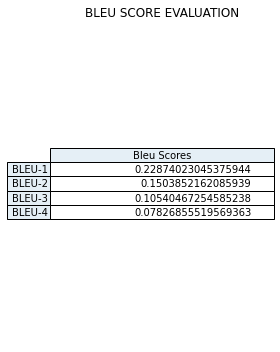

In [ ]:
rcolors = plt.cm.BuPu(np.full(len(row_headers[0]), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers[0]), 0.1))
plt.rcParams["figure.figsize"] = [4.00, 5.00]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
axs.axis('tight')
axs.axis('off')
table = plt.table(cellText=cell_text_bleu,
                    rowLabels=row_headers[0],
                    rowColours=rcolors,
                    colColours = ccolors,
                    colLabels=column_headers[0],
                    loc='center')
plt.title('BLEU SCORE EVALUATION')
plt.show()

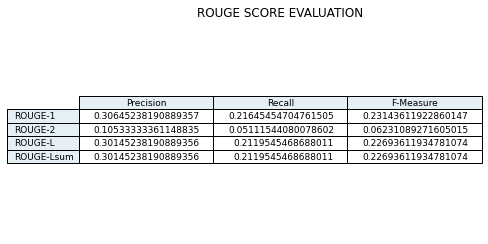

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
rcolors = plt.cm.BuPu(np.full(len(row_headers[1]), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers[1]), 0.1))
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = cell_text_rouge
columns = column_headers[1]
rows = row_headers[1]
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, 
                      colLabels=columns,
                      rowLabels=rows,
                      rowColours = rcolors,
                      colColours = ccolors,
                      loc='center')
plt.title('ROUGE SCORE EVALUATION')
plt.show()